构建你自己的 `Dataset` 类是一个非常灵活的方式，可以让你更好地控制数据加载过程。PyTorch 提供了一个基础的 `torch.utils.data.Dataset` 类，你可以通过继承它来创建自定义的数据集类。这允许你处理各种不同的数据源和格式，并且可以根据需要进行预处理。

### 📌 创建自定义 Dataset 类的基本步骤

1. **继承 `torch.utils.data.Dataset`**。
2. **实现 `__init__`, `__len__`, 和 `__getitem__` 方法**。

#### 示例：假设你有一个图像文件夹结构如下：

```
data/
    train/
        class_1/
            img1.jpg
            img2.jpg
            ...
        class_2/
            img1.jpg
            ...
    val/
        ...
```
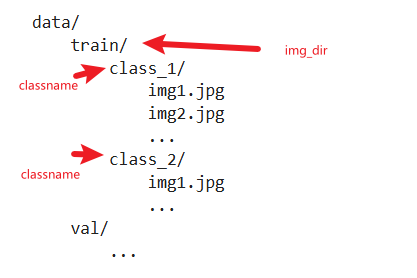

但你希望添加一些额外的功能（如数据增强、标签转换等），或者你的数据不是按照 ImageFolder 的结构组织的，那么你可以创建一个自定义的 Dataset 类。

---

## ✅ 示例代码：创建一个简单的自定义 Dataset 类

```python
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        """
        初始化数据集
        
        :param img_dir: 图像所在的目录路径
        :param transform: 对图像进行的变换（如数据增强）
        :param target_transform: 对标签进行的变换
        """
        self.img_labels = []
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # 遍历目录下的每个子文件夹（类别）
        for label_idx, class_name in enumerate(sorted(os.listdir(img_dir))):
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.img_labels.append((img_path, label_idx)) #如[(data/train/class_1/img1.jpg,0),(data/train/class_1/img2.jpg,0)......,(data/train/class_2/img1.jpg,1),(data/train/class_2/img2.jpg,1)...]
    
    def __len__(self):
        """返回数据集的大小"""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """获取指定索引处的数据样本"""
        img_path, label = self.img_labels[idx] #因为self.img_labels是列表嵌套元组,所以可以这样直接取到图片路径以及对应的类的编号
        image = Image.open(img_path).convert('RGB')  # 确保所有图像是 RGB 格式
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
```

---

### 🚀 如何使用这个自定义 Dataset？

```python
# 定义一些基本的图像变换
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 创建自定义数据集实例
train_dataset = CustomImageDataset(img_dir='./data/train', transform=transform)

# 使用 DataLoader 加载数据
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 训练循环中使用
for images, labels in train_loader:
    # 在这里进行训练操作...
    pass
```

---

## 🛠️ 自定义 Dataset 的优点

- **灵活性**：可以轻松处理非标准的数据组织形式。
- **扩展性**：可以方便地添加自定义的数据处理逻辑（如数据清洗、增强等）。
- **可控性**：直接控制如何读取、解析和转换数据。

---

## 🧪 扩展功能示例

### 1. 添加数据增强

在上面的例子中，我们已经使用了 `transforms.Compose` 来定义图像变换。你可以根据需要添加更多的数据增强方法，比如随机裁剪、水平翻转等：

```python
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
```

### 2. 处理 CSV 文件中的标注信息

如果你的数据标注不在文件夹结构中，而是存储在一个 CSV 文件里，你可以这样修改 `CustomImageDataset`：

```python
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.img_labels.iloc[idx, 1]  # 假设第二列是标签
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
```

在这个例子中，假设 CSV 文件的第一列是图像文件名，第二列是对应的标签。

---

## ✅ 总结

- **`torchvision.datasets.ImageFolder`** 是一个便捷的方法，适用于标准的文件夹结构。
- **自定义 `Dataset` 类** 提供了更高的灵活性，适合于复杂的数据集结构或需要特殊处理的情况。
- 实现自定义 Dataset 主要涉及三个方法：`__init__`, `__len__`, 和 `__getitem__`。

如果你有更具体的需求或问题（例如处理视频数据、时间序列数据等），也可以告诉我，我可以提供更有针对性的帮助 😊

当然可以！让我们一步步详细解读这段代码，尤其是你提到的**遍历目录下的每个子文件夹（类别）**的部分。

---

## 📌 代码详解

### 1. **导入必要的库**

```python
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
```

- `os`: 提供了与操作系统交互的功能，这里主要用于遍历文件系统。
- `PIL.Image`: Python Imaging Library (PIL) 的一部分，用于图像处理。`Image.open()` 可以打开图像文件并进行各种操作。
- `torch.utils.data.Dataset`: PyTorch 中所有自定义数据集类的基础类，你需要继承它来创建自己的数据集。
- `torchvision.transforms`: 提供了一系列常用的图像变换方法，如裁剪、缩放、归一化等。

---

### 2. **定义 `CustomImageDataset` 类**

```python
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        """
        初始化数据集
        
        :param img_dir: 图像所在的目录路径
        :param transform: 对图像进行的变换（如数据增强）
        :param target_transform: 对标签进行的变换
        """
        self.img_labels = []
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # 遍历目录下的每个子文件夹（类别）
        for label_idx, class_name in enumerate(sorted(os.listdir(img_dir))):
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.img_labels.append((img_path, label_idx))
```

#### 🔍 关键点：遍历目录结构

假设你的数据集目录结构如下：

```
data/
    train/
        cats/
            cat1.jpg
            cat2.jpg
            ...
        dogs/
            dog1.jpg
            dog2.jpg
            ...
```

在这个例子中，`train/` 目录下有两个子文件夹 `cats/` 和 `dogs/`，每个子文件夹代表一个类别。`cats/` 文件夹中的所有图片属于“猫”这一类别，`dogs/` 文件夹中的所有图片属于“狗”这一类别。

#### 2.1 **`os.listdir(img_dir)`**

```python
for label_idx, class_name in enumerate(sorted(os.listdir(img_dir))):
```

- `os.listdir(img_dir)` 返回 `img_dir` 目录下的所有文件和文件夹的名称列表。
- `sorted(...)` 对返回的列表进行排序，确保类别顺序一致（例如按字母顺序排列）。
- `enumerate(...)` 为每个类别名分配一个索引 `label_idx`，这个索引就是该类别的标签（Label）。比如 `cats` 可能对应 `0`，`dogs` 对应 `1`。

#### 2.2 **检查是否是文件夹**

```python
class_dir = os.path.join(img_dir, class_name)
if os.path.isdir(class_dir):
```

- `os.path.join(img_dir, class_name)` 将 `img_dir` 和 `class_name` 拼接成完整的路径，指向某个类别对应的文件夹。
- `os.path.isdir(class_dir)` 检查该路径是否是一个文件夹。这一步很重要，因为有时候目录下可能会有一些非文件夹的文件（如 `.DS_Store` 或其他配置文件），我们需要忽略它们。

#### 2.3 **遍历每个类别的图像**

```python
for img_name in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_name)
    self.img_labels.append((img_path, label_idx))
```

- `os.listdir(class_dir)` 列出某个类别文件夹下的所有文件（即图像文件）。
- `os.path.join(class_dir, img_name)` 拼接出每张图像的完整路径。
- `(img_path, label_idx)` 是一个元组，包含图像的路径和对应的标签（类别索引）。我们将这些元组添加到 `self.img_labels` 列表中。

最终，`self.img_labels` 列表会包含所有图像的路径及其对应的类别标签。例如：

```python
[
    ('data/train/cats/cat1.jpg', 0),
    ('data/train/cats/cat2.jpg', 0),
    ('data/train/dogs/dog1.jpg', 1),
    ('data/train/dogs/dog2.jpg', 1),
    ...
]
```

---

### 3. **实现 `__len__` 方法**

```python
def __len__(self):
    """返回数据集的大小"""
    return len(self.img_labels)
```

- `__len__` 方法返回数据集的大小，即 `self.img_labels` 列表的长度。这允许你在训练时知道数据集有多少个样本。

---

### 4. **实现 `__getitem__` 方法**

```python
def __getitem__(self, idx):
    """获取指定索引处的数据样本"""
    img_path, label = self.img_labels[idx]
    image = Image.open(img_path).convert('RGB')  # 确保所有图像是 RGB 格式
    
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    
    return image, label
```

#### 4.1 **加载图像**

- `img_path, label = self.img_labels[idx]`: 获取第 `idx` 个样本的图像路径和标签。
- `Image.open(img_path).convert('RGB')`: 使用 PIL 打开图像，并将其转换为 RGB 格式（即使原始图像是灰度图或带有透明通道的 PNG，也统一转换为 RGB）。

#### 4.2 **应用变换**

- `self.transform(image)`: 如果定义了 `transform`，则对图像进行预处理（如调整大小、裁剪、归一化等）。
- `self.target_transform(label)`: 如果定义了 `target_transform`，则对标签进行变换（通常不需要，但在某些情况下可能有用，如将标签转换为 one-hot 编码）。

#### 4.3 **返回图像和标签**

- 最终返回经过处理的图像和对应的标签。

---

## 🧪 示例：如何使用这个自定义 Dataset？

### 1. 定义图像变换

```python
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.ToTensor(),          # 转换为 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 归一化
])
```

### 2. 创建 Dataset 实例

```python
dataset = CustomImageDataset(img_dir='./data/train', transform=transform)
```

### 3. 使用 DataLoader 加载数据

```python
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 训练循环中使用
for images, labels in dataloader:
    # 在这里进行训练操作...
    pass
```

---

## ✅ 总结

- **`os.listdir(img_dir)`**: 列出给定目录下的所有文件和文件夹。
- **`os.path.join(img_dir, class_name)`**: 构建完整路径。
- **`os.path.isdir(class_dir)`**: 检查路径是否为文件夹，避免处理非文件夹项。
- **`self.img_labels.append((img_path, label_idx))`**: 将图像路径和对应的类别索引保存到列表中，以便后续访问。

通过这种方式，你可以灵活地处理各种不同的数据集结构，并且可以根据需要进行扩展和修改（如添加更多的数据增强、处理不同格式的标注文件等）。如果你有更多具体的需求或问题，欢迎继续提问 😊

## 初体验

In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [11]:
class myDataset(Dataset):      
    #必须创建方法,一个是__init__一个是__getitem__的方法,还有就是__len__方法  
    def __init__(self,img_dir):  
        self.img_dir = img_dir 
    def __getitem__(self,idx): #要想实现切片的话需要给他一个index参数  
        img_dir = self.img_dir[idx]
        return img_dir 
    def __len__(self): 
        return len(self.img_dir)

## 利用glob获取指定规则的文件

In [1]:
import glob  

In [2]:
all_imgs_path = glob.glob(r'../01计算机视觉基础/dataset2/*.jpg') #获取所有jpg文件

In [4]:
all_imgs_path[:5]  #获取前5个

['../01计算机视觉基础/dataset2\\cloudy1.jpg',
 '../01计算机视觉基础/dataset2\\cloudy10.jpg',
 '../01计算机视觉基础/dataset2\\cloudy100.jpg',
 '../01计算机视觉基础/dataset2\\cloudy101.jpg',
 '../01计算机视觉基础/dataset2\\cloudy102.jpg']

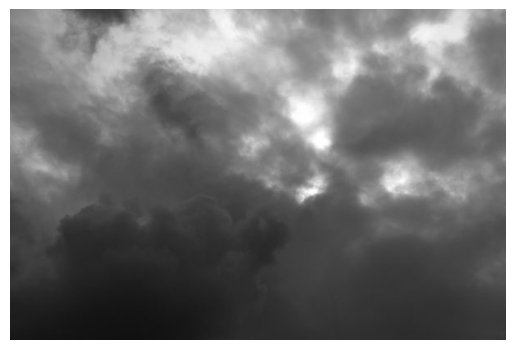

In [8]:
import matplotlib.pyplot as plt 
from PIL import Image
img_0 = all_imgs_path[0] 
img_my = Image.open(img_0).convert('RGB')
plt.axis('off')
plt.imshow(img_my)

## 使用自己定义的类创建dataset 

In [12]:
mydataset = myDataset(img_dir=all_imgs_path)

In [13]:
len(mydataset)

1122

In [16]:
mydataset[1]

'../01计算机视觉基础/dataset2\\cloudy100.jpg'

## 然后可以创建dataloader 

In [17]:
from torch.utils.data import DataLoader
mydataloader = DataLoader(mydataset,shuffle=True,batch_size=64)

## 拿到一个批次的数据 

In [18]:
next(iter(mydataloader))

['../01计算机视觉基础/dataset2\\rain150.jpg',
 '../01计算机视觉基础/dataset2\\rain180.jpg',
 '../01计算机视觉基础/dataset2\\cloudy236.jpg',
 '../01计算机视觉基础/dataset2\\shine13.jpg',
 '../01计算机视觉基础/dataset2\\sunrise138.jpg',
 '../01计算机视觉基础/dataset2\\shine87.jpg',
 '../01计算机视觉基础/dataset2\\sunrise283.jpg',
 '../01计算机视觉基础/dataset2\\shine57.jpg',
 '../01计算机视觉基础/dataset2\\cloudy232.jpg',
 '../01计算机视觉基础/dataset2\\shine7.jpg',
 '../01计算机视觉基础/dataset2\\sunrise302.jpg',
 '../01计算机视觉基础/dataset2\\sunrise103.jpg',
 '../01计算机视觉基础/dataset2\\sunrise174.jpg',
 '../01计算机视觉基础/dataset2\\sunrise109.jpg',
 '../01计算机视觉基础/dataset2\\cloudy199.jpg',
 '../01计算机视觉基础/dataset2\\sunrise351.jpg',
 '../01计算机视觉基础/dataset2\\sunrise55.jpg',
 '../01计算机视觉基础/dataset2\\cloudy209.jpg',
 '../01计算机视觉基础/dataset2\\shine119.jpg',
 '../01计算机视觉基础/dataset2\\rain162.jpg',
 '../01计算机视觉基础/dataset2\\cloudy17.jpg',
 '../01计算机视觉基础/dataset2\\sunrise102.jpg',
 '../01计算机视觉基础/dataset2\\rain127.jpg',
 '../01计算机视觉基础/dataset2\\sunrise338.jpg',
 '../01计算机视觉基础/dataset2\\c

In [19]:
mydataloader

## 完整示例,结合上面的glob

In [20]:
all_imgs_path = glob.glob(r'../01计算机视觉基础/dataset2/*.jpg') #获取所有jpg文件

In [29]:
all_imgs_path

['../01计算机视觉基础/dataset2\\cloudy1.jpg',
 '../01计算机视觉基础/dataset2\\cloudy10.jpg',
 '../01计算机视觉基础/dataset2\\cloudy100.jpg',
 '../01计算机视觉基础/dataset2\\cloudy101.jpg',
 '../01计算机视觉基础/dataset2\\cloudy102.jpg',
 '../01计算机视觉基础/dataset2\\cloudy103.jpg',
 '../01计算机视觉基础/dataset2\\cloudy104.jpg',
 '../01计算机视觉基础/dataset2\\cloudy105.jpg',
 '../01计算机视觉基础/dataset2\\cloudy106.jpg',
 '../01计算机视觉基础/dataset2\\cloudy107.jpg',
 '../01计算机视觉基础/dataset2\\cloudy108.jpg',
 '../01计算机视觉基础/dataset2\\cloudy109.jpg',
 '../01计算机视觉基础/dataset2\\cloudy11.jpg',
 '../01计算机视觉基础/dataset2\\cloudy110.jpg',
 '../01计算机视觉基础/dataset2\\cloudy111.jpg',
 '../01计算机视觉基础/dataset2\\cloudy112.jpg',
 '../01计算机视觉基础/dataset2\\cloudy113.jpg',
 '../01计算机视觉基础/dataset2\\cloudy114.jpg',
 '../01计算机视觉基础/dataset2\\cloudy115.jpg',
 '../01计算机视觉基础/dataset2\\cloudy116.jpg',
 '../01计算机视觉基础/dataset2\\cloudy117.jpg',
 '../01计算机视觉基础/dataset2\\cloudy118.jpg',
 '../01计算机视觉基础/dataset2\\cloudy119.jpg',
 '../01计算机视觉基础/dataset2\\cloudy12.jpg',
 '../01计算机视觉基础/datase

In [21]:
species = ['cloudy','rain','shine','sunrise'] 
species_to_idx = dict((c,i) for i,c in enumerate(species))
species_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [22]:
index_to_species = dict((v,k) for k,v in species_to_idx.items()) 
index_to_species

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

In [23]:
all_labels = [] 
for img in all_imgs_path: 
    for i,c in enumerate(species): 
        if c in img: 
            all_labels.append(i) 
all_labels         

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [24]:
all_labels[:5]

[0, 0, 0, 0, 0]

In [25]:
all_labels[-5:]

[3, 3, 3, 3, 3]

In [26]:
all_imgs_path[-5:]

['../01计算机视觉基础/dataset2\\sunrise95.jpg',
 '../01计算机视觉基础/dataset2\\sunrise96.jpg',
 '../01计算机视觉基础/dataset2\\sunrise97.jpg',
 '../01计算机视觉基础/dataset2\\sunrise98.jpg',
 '../01计算机视觉基础/dataset2\\sunrise99.jpg']

In [27]:
transform = transforms.Compose(
    [
        transforms.Resize((96,96)),
        transforms.ToTensor(), 
    ]
)

```python
class myDataset(Dataset): 
    def __init__(self,img_path,labels,transforms): 
        self.img_path = img_path, 
        self.labels = labels,
        self.transform = transforms
    def __len__(self): 
        return len(self.img_path) 
    def __getitem__(self,index):
        img_path = self.img_path[index], 
        label= self.labels[index], #这样就得到了对应的图片路径和图片标签

        img = Image.open(img).convert('RGB'), 
        if self.transform: #如果有transform操作那就进行转换
            img = self.transform(img)
        return img
```   

In [41]:
class myDataset(Dataset): 
    def __init__(self,img_path,labels,transforms): 
        self.img_path = img_path
        self.labels = labels
        self.transform = transforms
    def __len__(self): 
        return len(self.img_path) 
    def __getitem__(self,index):
        img_path = self.img_path[index]
        label= self.labels[index] #这样就得到了对应的图片路径和图片标签

        img = Image.open(img_path).convert('RGB')
        if self.transform: #如果有transform操作那就进行转换
            img = self.transform(img)
        return img,label

In [42]:
img_path_my = all_imgs_path
labels_my = all_labels
transform_my = transform 
mydataset = myDataset(img_path_my,labels_my,transform_my)  
type(mydataset)

__main__.myDataset

In [43]:
mydl = DataLoader(mydataset,
                  shuffle=True,
                  batch_size=64, num_workers=0 #这里提一个新的知识点,可以使用多进程
                 ) #创建dataloader

In [44]:
img_batch,label_batch = next(iter(mydl))

In [46]:
img_batch.shape

torch.Size([64, 3, 96, 96])

In [48]:
label_batch.shape

torch.Size([64])

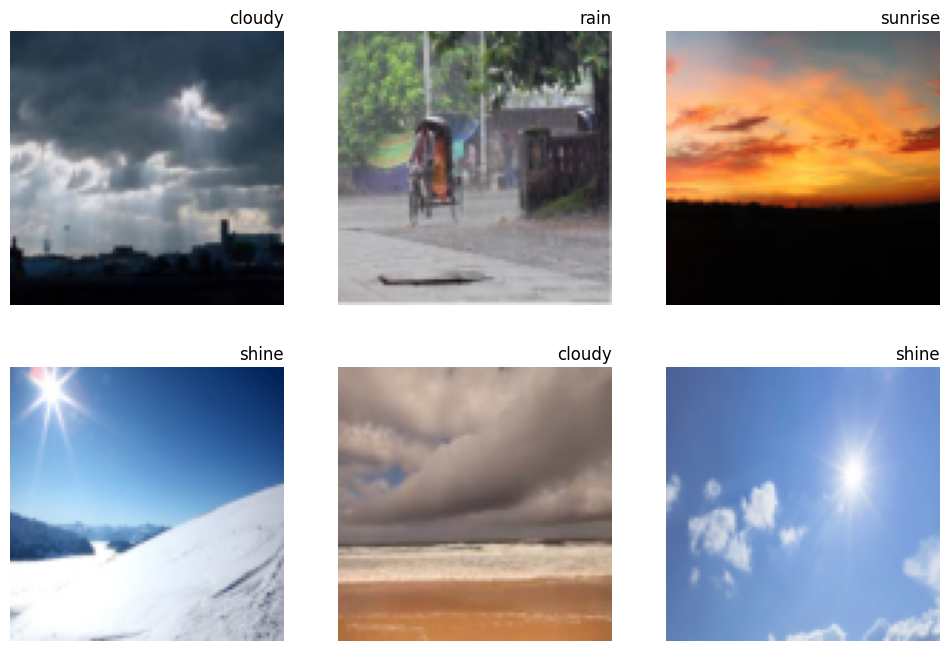

In [52]:
plt.figure(figsize=(12,8)) 
for idx,(iMg,lAbel) in enumerate(zip(img_batch[:6],label_batch[:6])):
    iMg = iMg.permute(1,2,0).numpy() #将chanel放在后面
    plt.subplot(2,3,idx+1)
    plt.title(index_to_species[lAbel.item()],loc='right') 
    plt.axis('off')
    plt.imshow(iMg)

In [ ]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc

    

## 高级写法 

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        """
        初始化数据集
        
        :param img_dir: 图像所在的目录路径
        :param transform: 对图像进行的变换（如数据增强）
        :param target_transform: 对标签进行的变换
        """
        self.img_labels = []
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # 遍历目录下的每个子文件夹（类别）
        for label_idx, class_name in enumerate(sorted(os.listdir(img_dir))):
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.img_labels.append((img_path, label_idx)) #如[(data/train/class_1/img1.jpg,0),(data/train/class_1/img2.jpg,0)......,(data/train/class_2/img1.jpg,1),(data/train/class_2/img2.jpg,1)...]
    
    def __len__(self):
        """返回数据集的大小"""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """获取指定索引处的数据样本"""
        img_path, label = self.img_labels[idx] #因为self.img_labels是列表嵌套元组,所以可以这样直接取到图片路径以及对应的类的编号
        image = Image.open(img_path).convert('RGB')  # 确保所有图像是 RGB 格式
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
